In [177]:
import numpy as np
import matplotlib.pyplot as plt
import gsd.hoomd
import hoomd
import os

In [183]:
def run_single_simulation(seed, n_steps, n_log_points, force_magnitude, rotational_diffusion, dt, kT):
    """Run a single simulation and return position trajectory"""
    
    # Setup initial conditions
    N_particles = 1
    L = 100000
    position = [[0, 0, 0]]
    
    # Create frame
    frame = gsd.hoomd.Frame()
    frame.particles.N = N_particles
    frame.particles.position = position[0:N_particles]
    frame.particles.typeid = [0] * N_particles
    frame.particles.types = ["A"]
    frame.particles.moment_inertia = [[1.0, 1.0, 1.0]] * N_particles  # Enable rotation
    frame.configuration.box = [L, L, L, 0, 0, 0]
    # Clean up any existing files
    filename = f"lattice_seed_{seed}.gsd"
    if os.path.exists(filename):
        os.remove(filename)
    
    with gsd.hoomd.open(name=filename, mode="x") as f:
        f.append(frame)
    
    # Create simulation
    cpu = hoomd.device.CPU()
    simulation = hoomd.Simulation(device=cpu, seed=seed)
    simulation.create_state_from_gsd(filename=filename)
    
    # Set up integrator and forces
    integrator = hoomd.md.Integrator(dt=dt, integrate_rotational_dof=True)
    
    if force_magnitude > 0:
        active_filter = hoomd.filter.Type(['A'])
        active_force = hoomd.md.force.Active(filter=active_filter)
        active_force.active_force['A'] = (force_magnitude, 0.0, 0.0)
        active_force.active_torque['A'] = (0.0, 0.0, 0.0)
        integrator.forces.append(active_force)
    
    
        # Modified Langevin: minimal translational effects, rotational diffusion only
    langevin = hoomd.md.methods.Langevin(filter=hoomd.filter.All(), kT=kT)  # Very low temperature
    
    # Minimal translational drag (particle motion dominated by active force)
    langevin.gamma['A'] = 100  # Very small translational drag
    
    # Rotational diffusion as desired
    langevin.gamma_r['A'] = (rotational_diffusion, rotational_diffusion, rotational_diffusion)
    
    integrator.methods.append(langevin)
    simulation.operations.integrator = integrator

    equilibration_steps = 10000  # Let system reach equilibrium
    simulation.run(equilibration_steps)
    equilibration_timestep = simulation.timestep
    # Store positions starting from equilibrated state
    positions = []
    times = []
    
    # Get initial position after equilibration
    snapshot = simulation.state.get_snapshot()
    initial_position = snapshot.particles.position[0].copy()
    positions.append(initial_position)
    times.append(simulation.timestep - equilibration_timestep)  # Reset time reference
    
    # Create logarithmic time points
    log_times = np.logspace(0, np.log10(n_steps), n_log_points, dtype=int)
    log_times = np.unique(log_times)  # Remove duplicates
    
    current_step = 0
    for target_step in log_times:
        steps_to_run = target_step - current_step
        if steps_to_run > 0:
            simulation.run(steps_to_run)
            snapshot = simulation.state.get_snapshot()
            positions.append(snapshot.particles.position[0].copy())
            times.append(simulation.timestep - equilibration_timestep)
            current_step = target_step
    
    # Clean up
    if os.path.exists(filename):
        os.remove(filename)
    
    return np.array(times), np.array(positions)

In [184]:
def calculate_msd(positions):
    """Calculate mean squared displacement from position trajectory"""
    initial_pos = positions[0]
    displacements = positions - initial_pos
    msd = np.sum(displacements**2, axis=1)
    return msd

In [185]:
def run_multiple_simulations(n_runs, n_steps, force_magnitude, rotational_diffusion, dt, kT, n_log_points):
    """Run multiple simulations and calculate average MSD"""
    
    all_msds = []
    all_times = []
    
    print(f"Running {n_runs} simulations...")
    
    for run_idx in range(n_runs):
        if run_idx % 10 == 0:
            print(f"Simulation {run_idx + 1}/{n_runs}")
        
        # Use different seed for each run
        seed = run_idx + 1
        times, positions = run_single_simulation(
            seed=seed, 
            n_steps=n_steps, 
            force_magnitude=force_magnitude,
            rotational_diffusion=rotational_diffusion,
            dt=dt,
            kT=kT, 
            n_log_points=n_log_points
        )
        
        msd = calculate_msd(positions)
        all_msds.append(msd)
        all_times.append(times)
    
    # Convert to arrays and calculate statistics
    min_length = min(len(msd) for msd in all_msds)
    all_msds = [msd[:min_length] for msd in all_msds]
    all_times = [times[:min_length] for times in all_times]
    
    all_msds = np.array(all_msds)
    avg_times = np.mean(all_times, axis=0)
    avg_msd = np.mean(all_msds, axis=0)
    
    return avg_times, avg_msd


In [203]:
def plot_multi_parameter_msd(results_dict, dt,kT):
    """Plot MSD results with proper unit conversion"""
    
    plt.figure(figsize=(10, 8))
    colors = ['red', 'orange', 'orange', 'gold']
    markers = ['o', '^', 's', 'd']
    
    for i, (force_mag, (times, avg_msd)) in enumerate(results_dict.items()):
        plt.loglog(times[1:], avg_msd[1:], 
          color=colors[i], marker=markers[i], 
          linewidth=2, markersize=4,
          label=f'F = {force_mag}')

    times_theory = np.logspace(0, 5, 100)
    msd_theory = 4 * kT * times_theory * dt  
    plt.loglog(times_theory, msd_theory, 'k--', alpha=0.5, label='∝t')
    
    plt.xlabel('time', fontsize=14)
    plt.ylabel('MSD', fontsize=14)
    plt.xlim(10,np.max(times))
    plt.grid(True, alpha=0.3)
    plt.legend(fontsize=12)
    plt.title('Mean Square Displacement of Active Brownian Particles', fontsize=14)
    plt.show()

In [205]:
if __name__ == "__main__":
    # Better parameters for clear regime visibility
    n_runs=100
    rotational_diffusion = 1    
    kT = 1                   
    dt = 0.001
    n_steps = 100000
    n_log_points = 100    # 100 logarithmically spaced points
    force_magnitudes = [0, 45, 90, 135]
    
    # Dictionary to store results
    results = {}
    
    # Run simulations for each force magnitude
    for force_mag in force_magnitudes:
        print(f"\n{'='*50}")
        print(f"Running simulations for force magnitude: {force_mag}")
        print(f"{'='*50}")
        
        times, avg_msd = run_multiple_simulations(
            n_runs=n_runs,
            n_steps=n_steps,

            force_magnitude=force_mag,
            rotational_diffusion=rotational_diffusion,
            dt=dt,
            kT=kT,
            n_log_points=n_log_points
        )
        
        results[force_mag] = (times, avg_msd)
    
    # Plot all results together
    print(f"\n{'='*50}")
    print("Plotting combined results...")
    print(f"{'='*50}")


Running simulations for force magnitude: 0
Running 100 simulations...
Simulation 1/100
Simulation 11/100
Simulation 21/100
Simulation 31/100
Simulation 41/100
Simulation 51/100
Simulation 61/100
Simulation 71/100
Simulation 81/100
Simulation 91/100

Running simulations for force magnitude: 45
Running 100 simulations...
Simulation 1/100
Simulation 11/100
Simulation 21/100
Simulation 31/100
Simulation 41/100
Simulation 51/100
Simulation 61/100
Simulation 71/100
Simulation 81/100
Simulation 91/100

Running simulations for force magnitude: 90
Running 100 simulations...
Simulation 1/100
Simulation 11/100
Simulation 21/100
Simulation 31/100
Simulation 41/100
Simulation 51/100
Simulation 61/100
Simulation 71/100
Simulation 81/100
Simulation 91/100

Running simulations for force magnitude: 135
Running 100 simulations...
Simulation 1/100
Simulation 11/100
Simulation 21/100
Simulation 31/100
Simulation 41/100
Simulation 51/100
Simulation 61/100
Simulation 71/100
Simulation 81/100
Simulation 91/

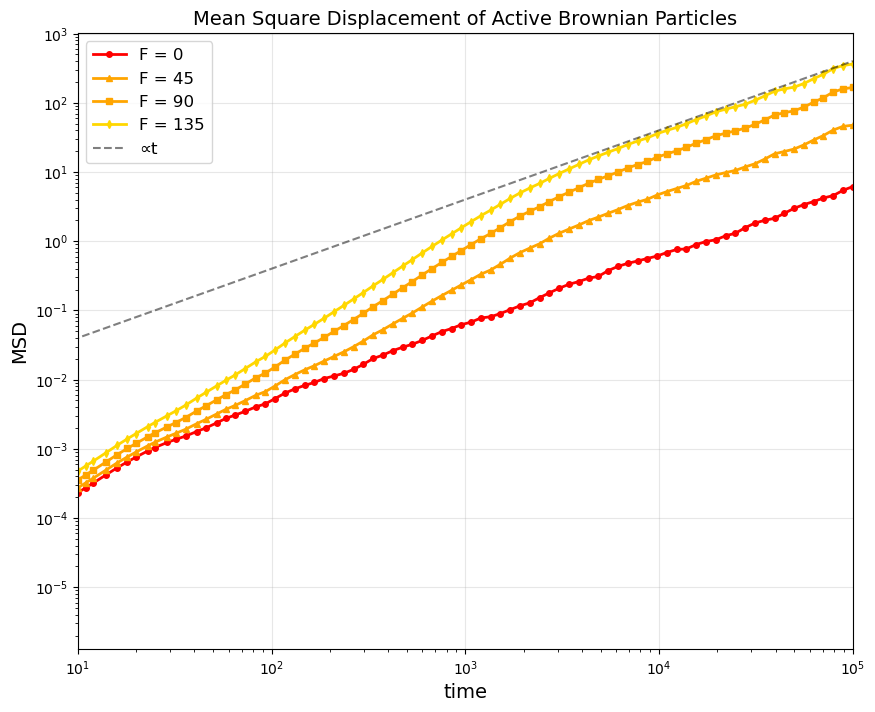

In [204]:
plot_multi_parameter_msd(results, dt, kT)